# Preprocessing

In [1]:
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import missingno as msno
import random
import re
from scipy.stats import kstest
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score,roc_curve
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import BayesianRidge
from scipy.stats import chi2_contingency
from scipy.stats import kstest
from scipy.stats import chisquare
from mixed_naive_bayes import MixedNB


In [2]:
def homogeneity_TF(df1,df2):
    p=0
    result=pd.DataFrame()
    for i in df1.columns:
        if i in ['id','target']:
            pass
        elif re.search('_cat',i):
            ct1=pd.crosstab(df1['target'],df1[i])
            ct2=pd.crosstab(df2['target'],df2[i])
            ct=pd.concat([ct1,ct2])
            chi2, p, dof, expected = chi2_contingency(ct)
        elif re.search('_bin',i):
            ct1=pd.crosstab(df1['target'],df1[i])
            ct2=pd.crosstab(df2['target'],df2[i])
            ct=pd.concat([ct1,ct2])
            chi2, p, dof, expected = chi2_contingency(ct)
        elif train[i].nunique()>100: #고유하게 나타나는 값이 100 이상일때는 KS Test 진행
            p=kstest(df1[i],df2[i])[1]
        else: # 그 외에는 Ordinal Data라고 가정하고 카이제곱검정 진행
            ct1=pd.crosstab(df1['target'],df1[i])
            ct2=pd.crosstab(df2['target'],df2[i])
            ct=pd.concat([ct1,ct2])
            ct.fillna(0,inplace=True)
            chi2, p, dof, expected = chi2_contingency(ct)
            
        temp=pd.DataFrame.from_dict([{'Variable': i,'p_value':round(p,4)}])
        result=pd.concat([result,temp])
        
    return result

In [3]:
def cramers_V(var1,var2) :
    crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
    stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
    obs = np.sum(crosstab) # Number of observations
    mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
    return (stat/(obs*mini))

In [4]:
random.seed(1111)

In [5]:
train=pd.read_csv('C:/Users/wpekt/Desktop/과제/P-SAT/방세/train.csv')
test=pd.read_csv('C:/Users/wpekt/Desktop/과제/P-SAT/방세/test.csv')

In [6]:
train_d=train.drop(['V24_cat','V26_cat'],axis=1)
test_d=test.drop(['V24_cat','V26_cat'],axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\missingno\missingno.py:61: UserWarning: Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.
  warnings.warn(


<AxesSubplot:>

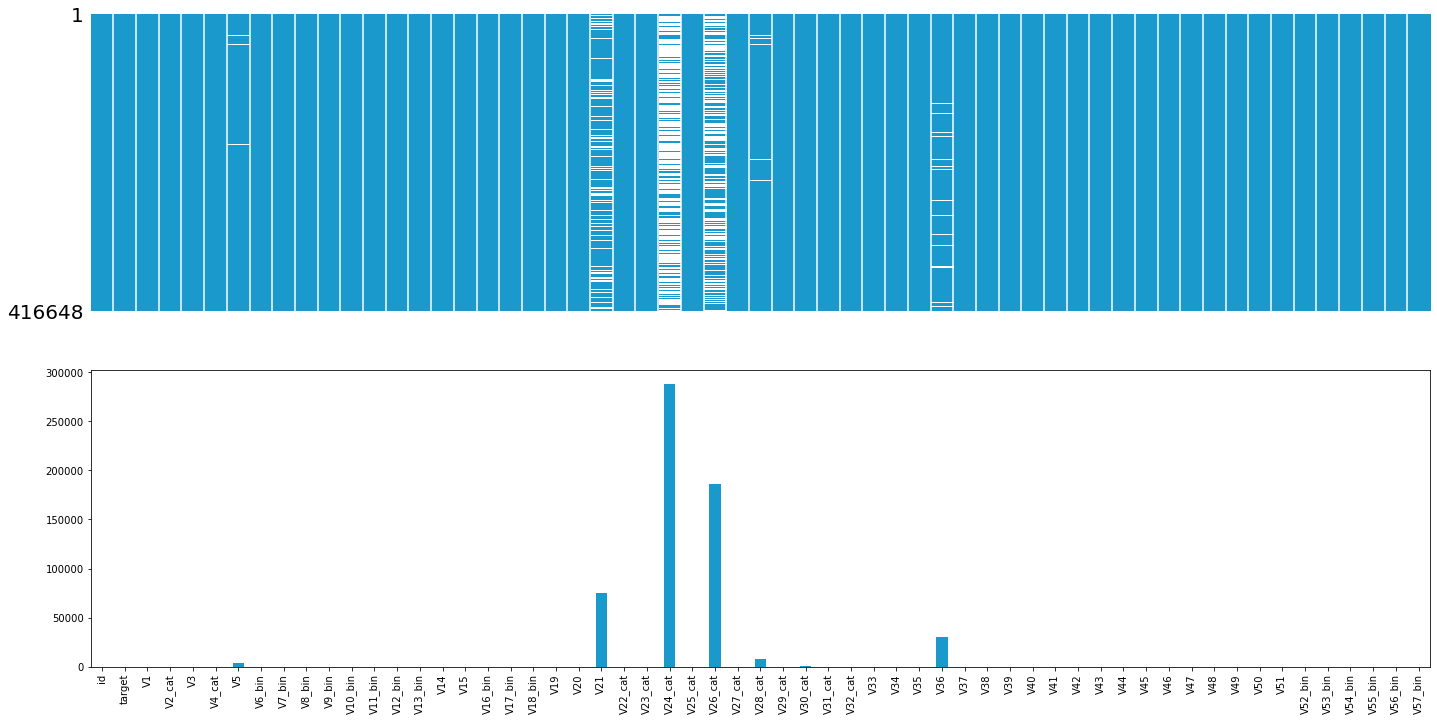

In [51]:
figure, axs = plt.subplots(nrows=2, ncols=1)
figure.set_size_inches(24,12)

msno.matrix(df=train.iloc[:, :], color=(0.1, 0.6, 0.8),ax=axs[0])
train.isna().sum().plot.bar(figsize = (24,12),color=(0.1, 0.6, 0.8))

데이터 확인 결과 결측치가 많이 발생하는 모습을 확인할 수 있음

In [7]:
naun_bf=pd.DataFrame({'na':train_d.isna().sum(),'nunique':train_d.nunique()})

In [8]:
col_cat=[]
col_num=[]
col_bin=[]
col_ord=[]
for i in train_d.columns.to_list()[2:]:
    if '_cat' in i:
        col_cat.append(i)
    elif re.search('_bin',i):
        col_bin.append(i)
    elif train_d[i].nunique()>100:
        col_num.append(i)
    else:
        col_ord.append(i)

In [9]:
display(col_cat)
display(col_num)
display(col_bin)
display(col_ord)

['V2_cat',
 'V4_cat',
 'V22_cat',
 'V23_cat',
 'V25_cat',
 'V27_cat',
 'V28_cat',
 'V29_cat',
 'V30_cat',
 'V31_cat',
 'V32_cat']

['V21', 'V34', 'V35', 'V36']

['V6_bin',
 'V7_bin',
 'V8_bin',
 'V9_bin',
 'V10_bin',
 'V11_bin',
 'V12_bin',
 'V13_bin',
 'V16_bin',
 'V17_bin',
 'V18_bin',
 'V52_bin',
 'V53_bin',
 'V54_bin',
 'V55_bin',
 'V56_bin',
 'V57_bin']

['V1',
 'V3',
 'V5',
 'V14',
 'V15',
 'V19',
 'V20',
 'V33',
 'V37',
 'V38',
 'V39',
 'V40',
 'V41',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51']

In [52]:
train_positive=train[train['target']==1]
train_negative=train[train['target']==0]

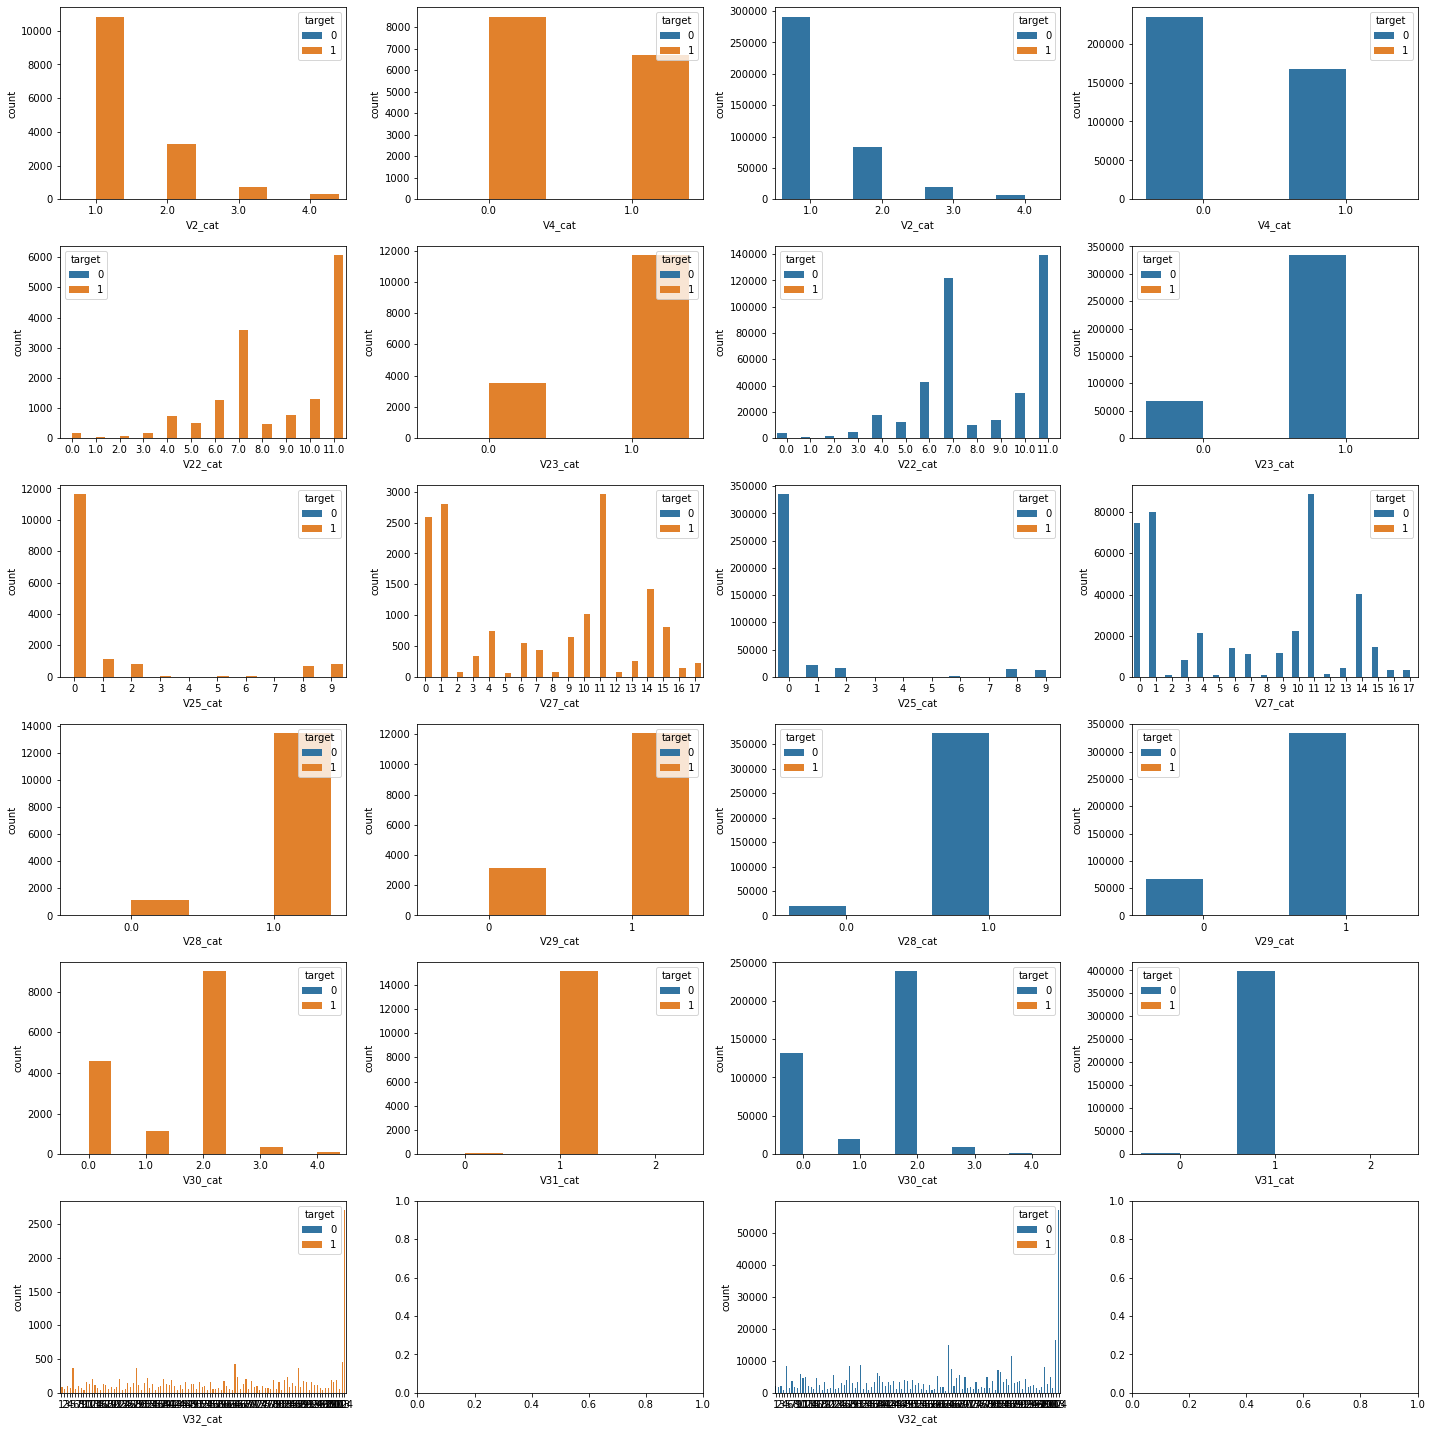

In [54]:
figure, axs = plt.subplots(nrows=(len(col_cat)//2)+1, ncols=4)
figure.set_size_inches(20,20)

for i, col in enumerate(train_positive[col_cat]):
    sns.countplot(x=train_positive[col],hue=train['target'],ax=axs[i//2,i%2])
    sns.countplot(x=train_negative[col],hue=train['target'],ax=axs[i//2,i%2+2])
figure.tight_layout() 

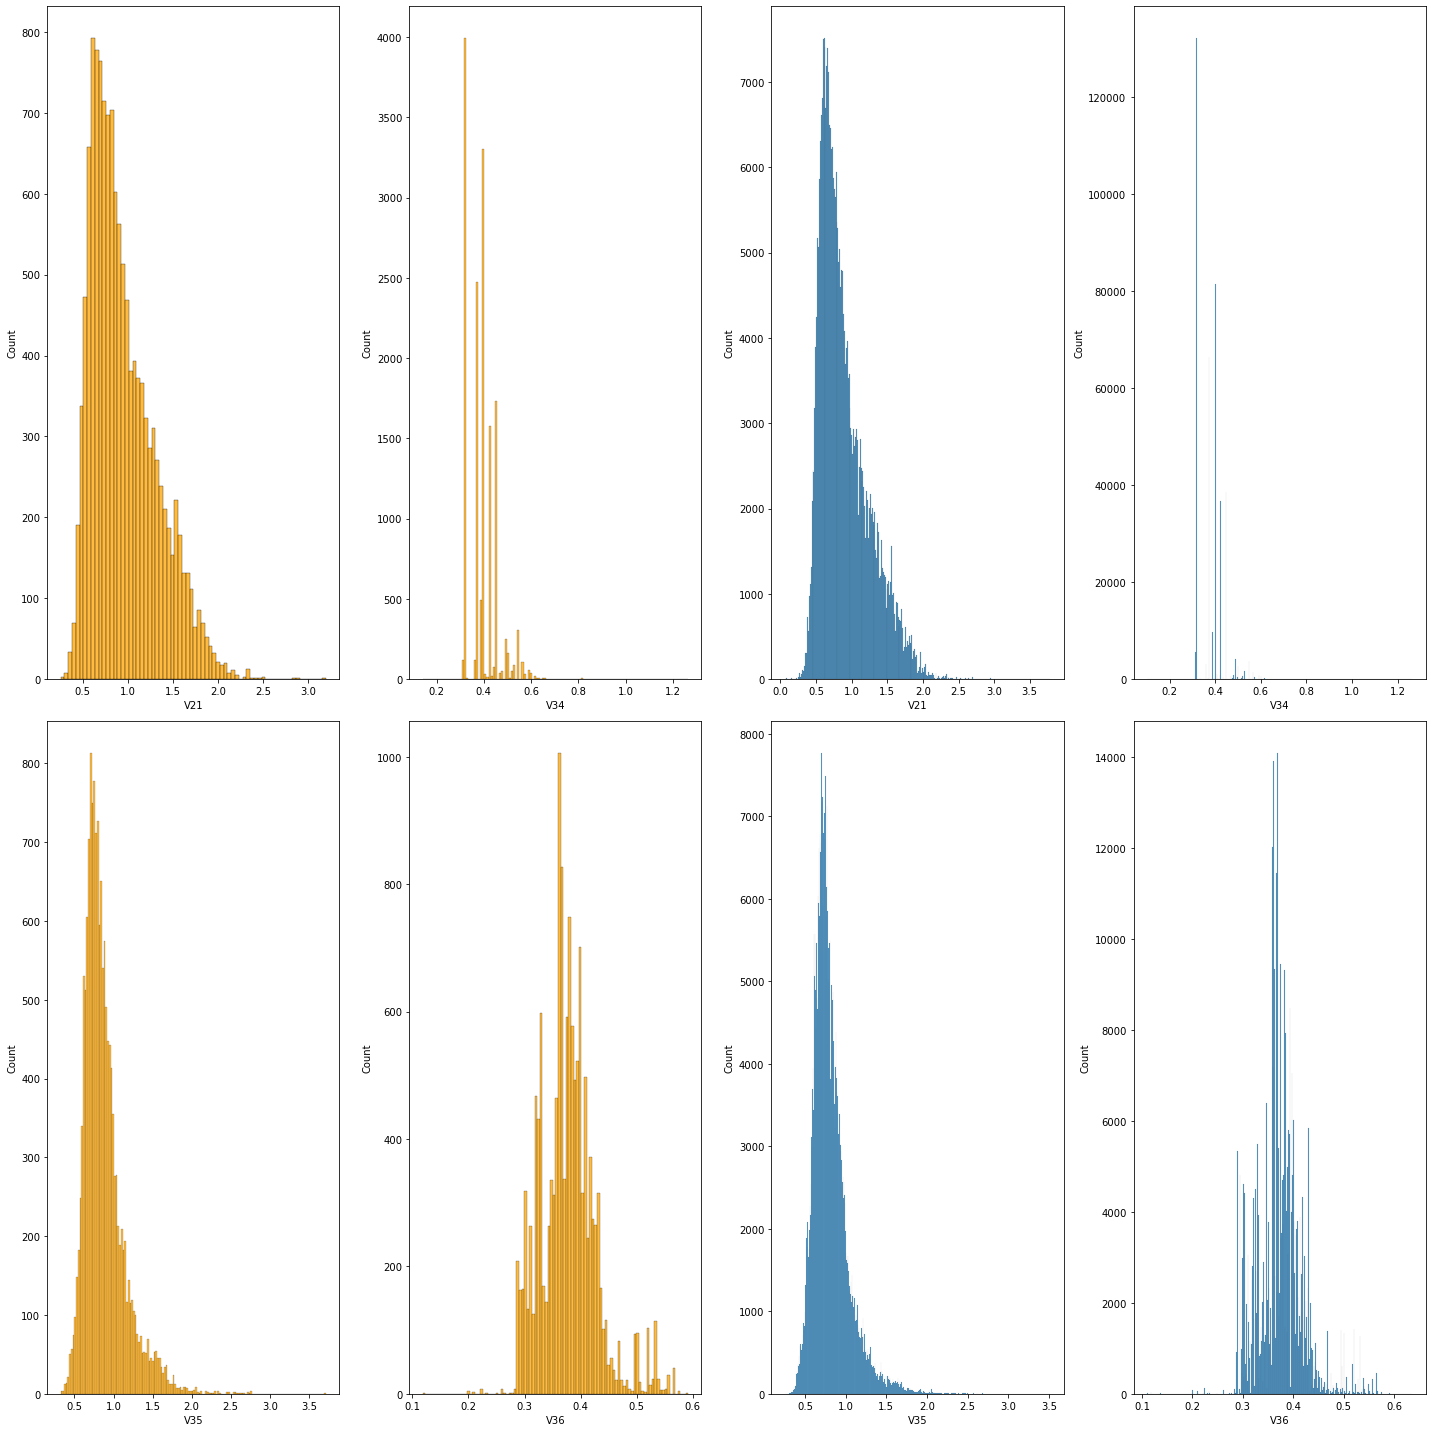

In [56]:
figure, axs = plt.subplots(nrows=(len(col_num)//2), ncols=4)
figure.set_size_inches(20,20)

for i, col in enumerate(train_positive[col_num]):
    sns.histplot(train_positive, x=col,color='orange',ax=axs[i//2,i%2])
    sns.histplot(train_negative, x=col,ax=axs[i//2,i%2+2])
figure.tight_layout() 

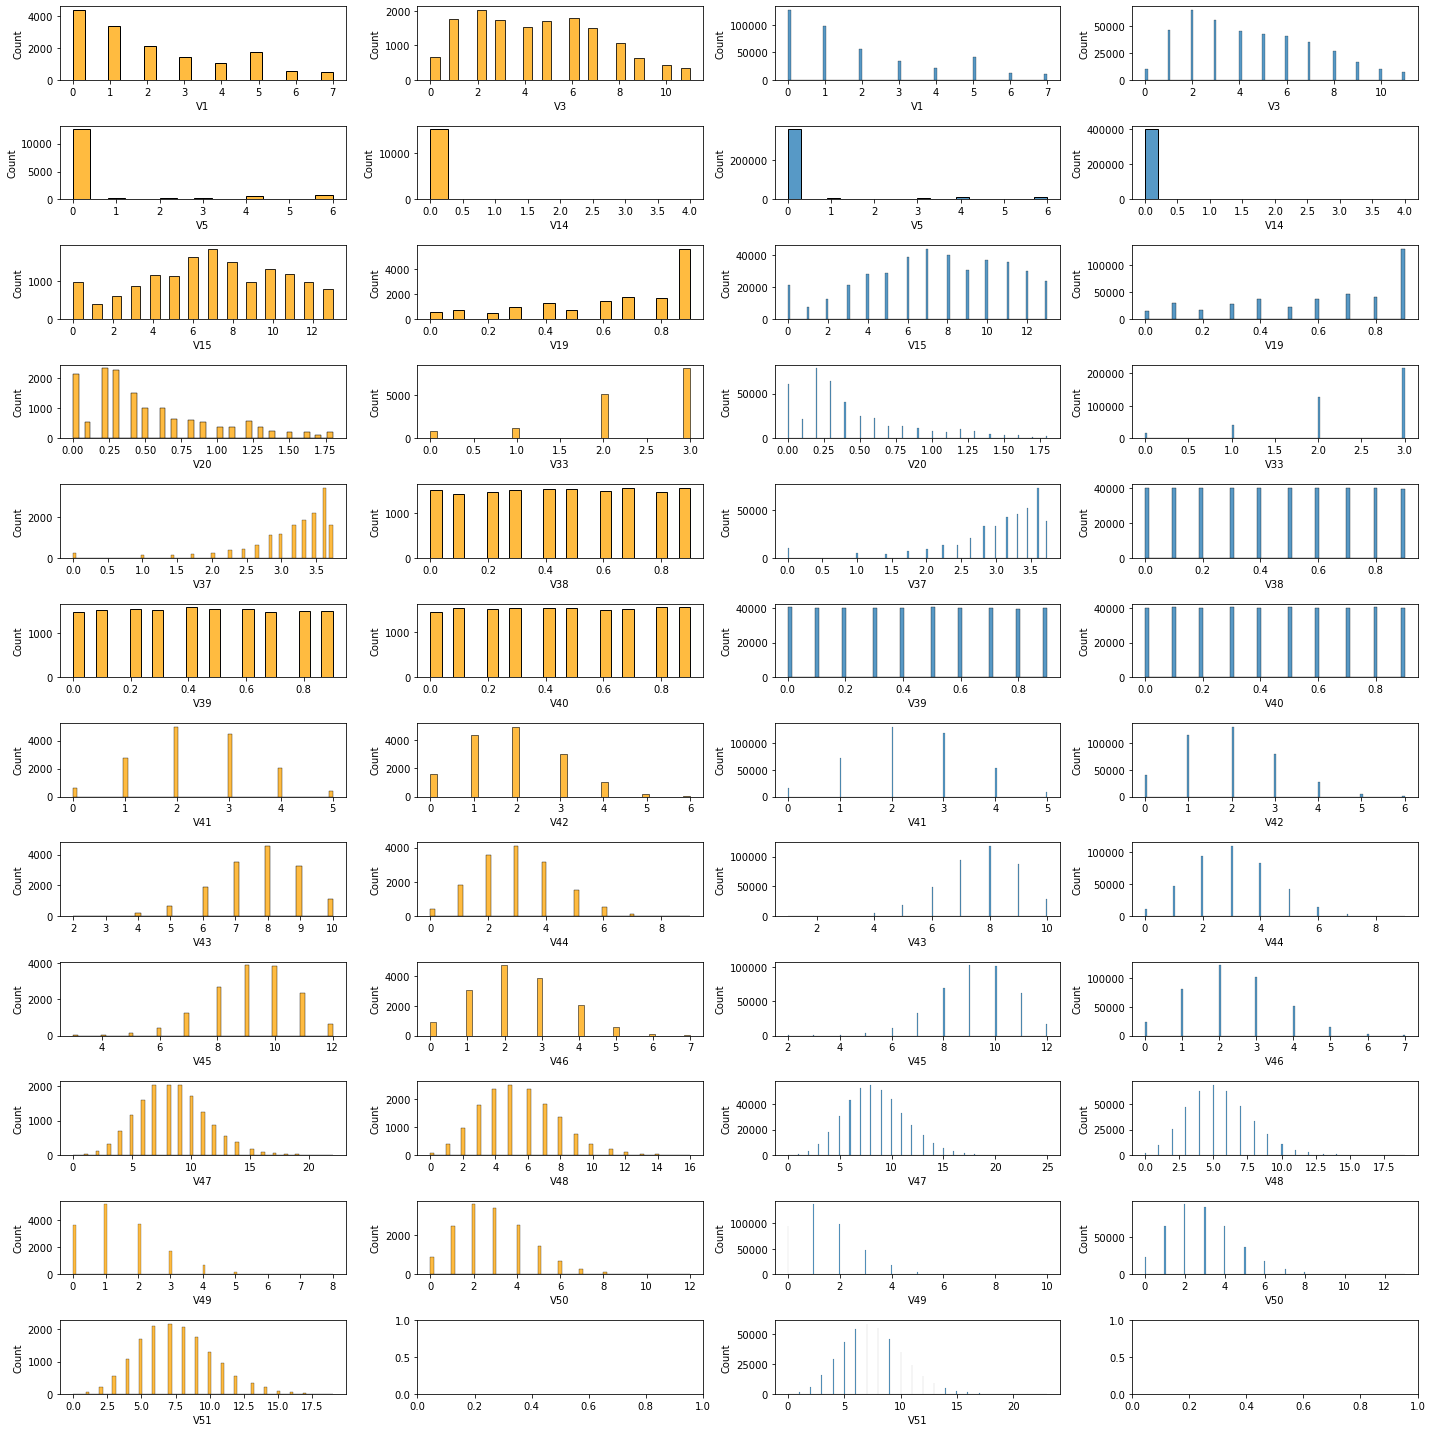

In [58]:
figure, axs = plt.subplots(nrows=(len(col_ord)//2)+1, ncols=4)
figure.set_size_inches(20,20)

for i, col in enumerate(train_positive[col_ord]):
    sns.histplot(train_positive, x=col,color='orange',ax=axs[i//2,i%2])
    sns.histplot(train_negative, x=col,ax=axs[i//2,i%2+2])
figure.tight_layout() 

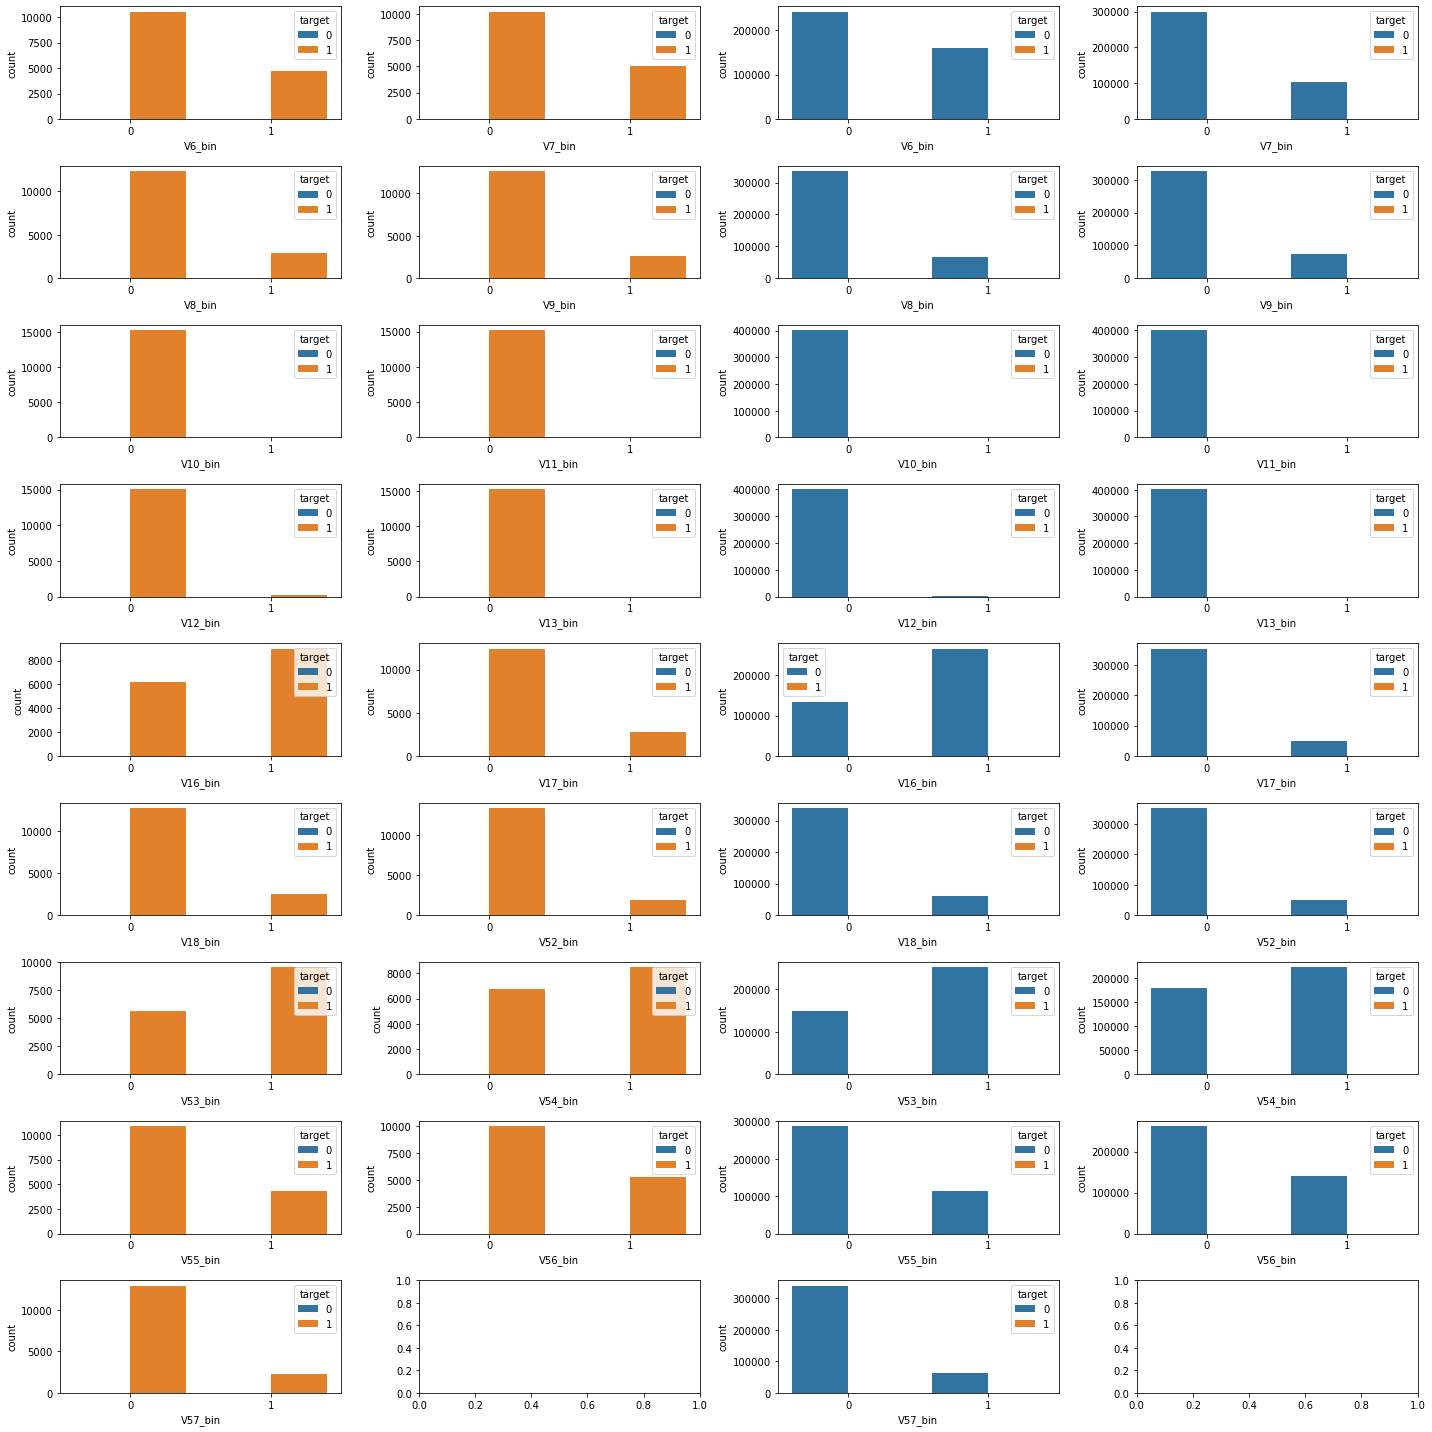

In [59]:
figure, axs = plt.subplots(nrows=(len(col_bin)//2)+1, ncols=4)
figure.set_size_inches(20,20)

for i, col in enumerate(train_positive[col_bin]):
    sns.countplot(x=train_positive[col],hue=train['target'],ax=axs[i//2,i%2])
    sns.countplot(x=train_negative[col],hue=train['target'],ax=axs[i//2,i%2+2])
figure.tight_layout() 

전체적으로 target값에 상관없이 분포가 비슷해 보이는 변수들이 존재하는 것을 확인 -> 추후 동질성 검사 실시

In [61]:
train.dtypes

id           int64
target       int64
V1           int64
V2_cat     float64
V3           int64
V4_cat     float64
V5         float64
V6_bin       int64
V7_bin       int64
V8_bin       int64
V9_bin       int64
V10_bin      int64
V11_bin      int64
V12_bin      int64
V13_bin      int64
V14          int64
V15          int64
V16_bin      int64
V17_bin      int64
V18_bin      int64
V19        float64
V20        float64
V21        float64
V22_cat    float64
V23_cat    float64
V24_cat    float64
V25_cat      int64
V26_cat    float64
V27_cat      int64
V28_cat    float64
V29_cat      int64
V30_cat    float64
V31_cat      int64
V32_cat      int64
V33        float64
V34        float64
V35        float64
V36        float64
V37        float64
V38        float64
V39        float64
V40        float64
V41          int64
V42          int64
V43          int64
V44          int64
V45          int64
V46          int64
V47          int64
V48          int64
V49          int64
V50          int64
V51         

In [10]:
col_na=train_d.columns[train_d.isna().sum()>0].to_list()

In [11]:
train_d[col_cat]=train_d[col_cat].fillna(-1).astype(pd.Int64Dtype()).replace({-1: np.nan})
test_d[col_cat]=test_d[col_cat].fillna(-1).astype(pd.Int64Dtype()).replace({-1: np.nan})

In [12]:
naun_bf

,na,nunique
id,0,416648
target,0,2
V1,0,8
V2_cat,151,4
V3,0,12
V4_cat,58,2
V5,4083,7
V6_bin,0,2
V7_bin,0,2
V8_bin,0,2


결측치를 보간하기 위해 사용할 수 있는 변수를 판별하기 위해 상관분석을 실시함

In [13]:
rows= []

for var1 in train_d[col_bin]:
    col = []
    for var2 in train[col_bin]:
        cramers =cramers_V(train_d[col_bin][var1], train_d[col_bin][var2]) # Cramer's V test
        col.append(round(cramers,4)) # Keeping of the rounded value of the Cramer's V  
    rows.append(col)
cramers_results = np.array(rows)
corr_bin = pd.DataFrame(cramers_results, columns =train_d[col_bin].columns, index =train_d[col_bin].columns)

In [14]:
rows= []

for var1 in train_d[col_ord]:
    col = []
    for var2 in train[col_ord]:
        cramers =cramers_V(train_d[col_ord][var1], train_d[col_ord][var2]) # Cramer's V test
        col.append(round(cramers,4)) # Keeping of the rounded value of the Cramer's V  
    rows.append(col)
cramers_results = np.array(rows)
corr_ord = pd.DataFrame(cramers_results, columns =train_d[col_ord].columns, index =train_d[col_ord].columns)

In [15]:
rows= []

for var1 in train_d[col_cat]:
    col = []
    for var2 in train[col_cat]:
        cramers =cramers_V(train_d[col_cat][var1], train_d[col_cat][var2]) # Cramer's V test
        col.append(round(cramers,4)) # Keeping of the rounded value of the Cramer's V  
    rows.append(col)
cramers_results = np.array(rows)
corr_cat = pd.DataFrame(cramers_results, columns =train_d[col_cat].columns, index =train_d[col_cat].columns)

In [16]:
corr_num=train_d[col_num].corr(method='pearson')

<AxesSubplot:>

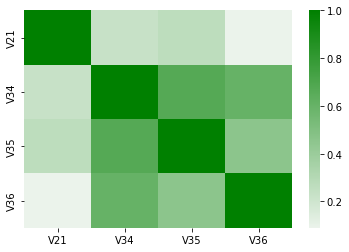

In [62]:
sns.heatmap(corr_num, annot=False, cmap=sns.light_palette("green", as_cmap=True))

<AxesSubplot:>

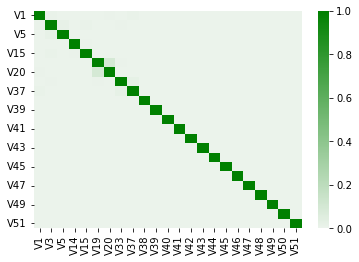

In [63]:
sns.heatmap(corr_ord, annot=False, cmap=sns.light_palette("green", as_cmap=True))

<AxesSubplot:>

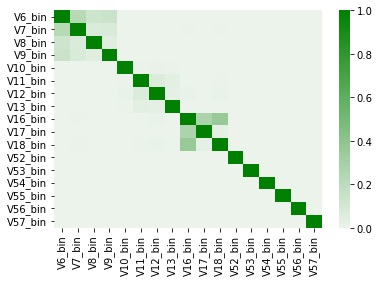

In [64]:
sns.heatmap(corr_bin, annot=False, cmap=sns.light_palette("green", as_cmap=True))

<AxesSubplot:>

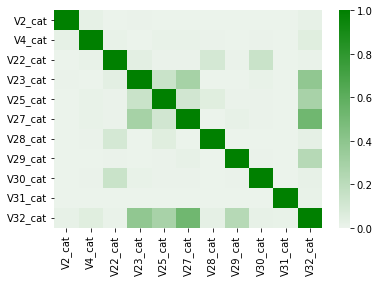

In [65]:
sns.heatmap(corr_cat, annot=False, cmap=sns.light_palette("green", as_cmap=True))

In [17]:
for i in col_na:
    if '_cat' in i:
        display(corr_cat[i][abs(corr_cat.loc[i])>0.1])    
    elif re.search('_bin',i):
        display(corr_bin[i][abs(corr_bin.loc[i])>0.1])
    elif train[i].nunique()>100:
        display(corr_num[i][abs(corr_num.loc[i])>0.1])
    else:
        display(corr_ord[i][abs(corr_ord.loc[i])>0.1])

V2_cat    1.0
Name: V2_cat, dtype: float64

V4_cat    1.0
Name: V4_cat, dtype: float64

V5    1.0
Name: V5, dtype: float64

V21    1.000000
V34    0.228513
V35    0.265771
Name: V21, dtype: float64

V22_cat    1.0000
V30_cat    0.1436
Name: V22_cat, dtype: float64

V23_cat    1.0000
V25_cat    0.1433
V27_cat    0.2905
V32_cat    0.3815
Name: V23_cat, dtype: float64

V28_cat    1.0
Name: V28_cat, dtype: float64

V22_cat    0.1436
V30_cat    1.0000
Name: V30_cat, dtype: float64

V33    1.0
Name: V33, dtype: float64

V21    0.228513
V34    1.000000
V35    0.670736
V36    0.603076
Name: V34, dtype: float64

V34    0.603076
V35    0.459027
V36    1.000000
Name: V36, dtype: float64

상관관계 분석 결과 연속형 변수를 제외하면 같은 유형의 변수들 간 상관관계가 낮은 모습을 확인

In [18]:
naun_bf

,na,nunique
id,0,416648
target,0,2
V1,0,8
V2_cat,151,4
V3,0,12
V4_cat,58,2
V5,4083,7
V6_bin,0,2
V7_bin,0,2
V8_bin,0,2


In [19]:
train_pos_d=train_d[train_d['target']==1]
train_neg_d=train_d[train_d['target']==0]

target이 1일때와 0일때 분포가 비슷한 경우를 발견하여, 좀 더 이를 구분할 수 있는 결정적인 변수를 찾기 위해 모든 변수에 대한 동질성 검정 실시

In [20]:
hr=homogeneity_TF(train_pos_d,train_neg_d)
hr_list=hr[hr['p_value']<0.05].iloc[2:]['Variable'].to_list()
hr_list

['V1',
 'V2_cat',
 'V3',
 'V4_cat',
 'V5',
 'V6_bin',
 'V7_bin',
 'V8_bin',
 'V9_bin',
 'V11_bin',
 'V12_bin',
 'V14',
 'V15',
 'V16_bin',
 'V17_bin',
 'V18_bin',
 'V19',
 'V20',
 'V21',
 'V22_cat',
 'V23_cat',
 'V25_cat',
 'V27_cat',
 'V28_cat',
 'V29_cat',
 'V30_cat',
 'V32_cat',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37']

In [21]:
col_cath=[]
col_numh=[]
col_binh=[]
col_ordh=[]
for i in hr_list:
    if '_cat' in i:
        col_cath.append(i)
    elif re.search('_bin',i):
        col_binh.append(i)
    elif train_d[i].nunique()>100:
        col_numh.append(i)
    else:
        col_ordh.append(i)

In [22]:
display(col_cath)
display(col_numh)
display(col_binh)
display(col_ordh)

['V2_cat',
 'V4_cat',
 'V22_cat',
 'V23_cat',
 'V25_cat',
 'V27_cat',
 'V28_cat',
 'V29_cat',
 'V30_cat',
 'V32_cat']

['V21', 'V34', 'V35', 'V36']

['V6_bin',
 'V7_bin',
 'V8_bin',
 'V9_bin',
 'V11_bin',
 'V12_bin',
 'V16_bin',
 'V17_bin',
 'V18_bin']

['V1', 'V3', 'V5', 'V14', 'V15', 'V19', 'V20', 'V33', 'V37']

순서형 데이터에 결측치가 발생하나 변수들 간 스케일이 다르기 때문에 이를 맞춰주기 위해서 Ordinal Encoding 실시

In [23]:
train_d[col_ordh].isna().sum()

V1        0
V3        0
V5     4083
V14       0
V15       0
V19       0
V20       0
V33       3
V37       0
dtype: int64

In [24]:
display(train_d['V5'].value_counts())
display(train_d['V33'].value_counts())

0.0    369692
6.0     14499
4.0     12787
1.0      5803
3.0      5719
2.0      2936
5.0      1129
Name: V5, dtype: int64

3.0    223432
2.0    132299
1.0     42784
0.0     18130
Name: V33, dtype: int64

In [25]:
for i in col_ordh:
    train_d[i]=train_d[i].fillna(10)
    test_d[i]=test_d[i].fillna(10)

In [26]:
enc = OrdinalEncoder()
enc.fit(train_d[col_ordh])

OrdinalEncoder()

In [27]:
train_d[col_ordh]=enc.transform(train_d[col_ordh])
test_d[col_ordh]=enc.transform(test_d[col_ordh])

In [28]:
display(train_d['V5'].value_counts())
display(train_d['V33'].value_counts())

0.0    369692
6.0     14499
4.0     12787
1.0      5803
3.0      5719
7.0      4083
2.0      2936
5.0      1129
Name: V5, dtype: int64

3.0    223432
2.0    132299
1.0     42784
0.0     18130
4.0         3
Name: V33, dtype: int64

In [29]:
train_d['V5']=train_d['V5'].replace({7: np.nan})
train_d['V33']=train_d['V33'].replace({4: np.nan})
test_d['V5']=test_d['V5'].replace({7: np.nan})
test_d['V33']=test_d['V33'].replace({4: np.nan})


In [30]:
train_d[col_ordh]=train_d[col_ordh].fillna(-1).astype(pd.Int64Dtype()).replace({-1: np.nan})
test_d[col_ordh]=test_d[col_ordh].fillna(-1).astype(pd.Int64Dtype()).replace({-1: np.nan})

In [31]:
train_d[hr_list].dtypes

V1           Int64
V2_cat       Int64
V3           Int64
V4_cat       Int64
V5           Int64
V6_bin       int64
V7_bin       int64
V8_bin       int64
V9_bin       int64
V11_bin      int64
V12_bin      int64
V14          Int64
V15          Int64
V16_bin      int64
V17_bin      int64
V18_bin      int64
V19          Int64
V20          Int64
V21        float64
V22_cat      Int64
V23_cat      Int64
V25_cat      Int64
V27_cat      Int64
V28_cat      Int64
V29_cat      Int64
V30_cat      Int64
V32_cat      Int64
V33          Int64
V34        float64
V35        float64
V36        float64
V37          Int64
dtype: object

Ordinal Encoding 및 변수들의 자료형을 각 변수들의 특성에 따라 변경하여 잘 변경된 것을 확인

결측치가 발생하는 연속형, 순서형, 범주형 데이터에 보간을 진행, 연속형 자료끼리는 상관관계를 보이므로 Linear Model을 사용하여 보간해주고, 순서형, 범주형 자료는 상관관계가 낮기 때문에 Non-Linear한 모델을 

연속형 자료를 보간하기 위해서 Scikit-learn에서 진행한 결측치 보간 예제 비교 중 가장 좋은 성능을 보였던 BayesianRidge를 사용함

순서형, 범주형 자료는 RandomForestClassifier를 통해 보간하여 최대한 변수들이 가지는 특성을 보존할 수 있도록 보간함

In [32]:
imp_num = IterativeImputer(estimator=BayesianRidge(),max_iter=10, random_state=1111,verbose=True)
imp_cat = IterativeImputer(estimator=RandomForestClassifier(n_estimators=40,
                           max_depth=10,
                           bootstrap=True,
                           max_samples=0.5,
                           n_jobs=2),
                           initial_strategy='most_frequent',
                           max_iter=10, random_state=1111,verbose=True)
imp_ord = IterativeImputer(estimator=RandomForestClassifier(n_estimators=40,
                           max_depth=10,
                           bootstrap=True,
                           max_samples=0.5,
                           n_jobs=2),
                           initial_strategy='most_frequent',
                           max_iter=10, random_state=1111,verbose=True)

In [33]:
imp_num=imp_num.fit(train_d[col_numh])

[IterativeImputer] Completing matrix with shape (416648, 4)
[IterativeImputer] Change: 1.1067441538921612, scaled tolerance: 0.0037877268909000004 
[IterativeImputer] Change: 0.010449995442283422, scaled tolerance: 0.0037877268909000004 
[IterativeImputer] Change: 6.685679332174566e-05, scaled tolerance: 0.0037877268909000004 
[IterativeImputer] Early stopping criterion reached.


In [34]:
imp_cat=imp_cat.fit(train_d[col_cath])

[IterativeImputer] Completing matrix with shape (416648, 10)
[IterativeImputer] Change: 7.0, scaled tolerance: 0.10400000000000001 
[IterativeImputer] Change: 5.0, scaled tolerance: 0.10400000000000001 
[IterativeImputer] Change: 2.0, scaled tolerance: 0.10400000000000001 
[IterativeImputer] Change: 6.0, scaled tolerance: 0.10400000000000001 
[IterativeImputer] Change: 2.0, scaled tolerance: 0.10400000000000001 
[IterativeImputer] Change: 4.0, scaled tolerance: 0.10400000000000001 
[IterativeImputer] Change: 4.0, scaled tolerance: 0.10400000000000001 
[IterativeImputer] Change: 6.0, scaled tolerance: 0.10400000000000001 
[IterativeImputer] Change: 4.0, scaled tolerance: 0.10400000000000001 
[IterativeImputer] Change: 4.0, scaled tolerance: 0.10400000000000001 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


In [35]:
imp_ord=imp_ord.fit(train_d[col_ordh])

[IterativeImputer] Completing matrix with shape (416648, 9)
[IterativeImputer] Change: 6.0, scaled tolerance: 0.018000000000000002 
[IterativeImputer] Change: 6.0, scaled tolerance: 0.018000000000000002 
[IterativeImputer] Change: 6.0, scaled tolerance: 0.018000000000000002 
[IterativeImputer] Change: 6.0, scaled tolerance: 0.018000000000000002 
[IterativeImputer] Change: 6.0, scaled tolerance: 0.018000000000000002 
[IterativeImputer] Change: 6.0, scaled tolerance: 0.018000000000000002 
[IterativeImputer] Change: 6.0, scaled tolerance: 0.018000000000000002 
[IterativeImputer] Change: 6.0, scaled tolerance: 0.018000000000000002 
[IterativeImputer] Change: 6.0, scaled tolerance: 0.018000000000000002 
[IterativeImputer] Change: 6.0, scaled tolerance: 0.018000000000000002 


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


In [36]:
imp_num_train=imp_num.transform(train_d[col_numh])
imp_num_test=imp_num.transform(test_d[col_numh])

[IterativeImputer] Completing matrix with shape (416648, 4)
[IterativeImputer] Completing matrix with shape (178564, 4)


In [37]:
imp_cat_train=imp_cat.transform(train_d[col_cath])
imp_cat_test=imp_cat.transform(test_d[col_cath])

[IterativeImputer] Completing matrix with shape (416648, 10)
[IterativeImputer] Completing matrix with shape (178564, 10)


In [38]:
imp_ord_train=imp_ord.transform(train_d[col_ordh])
imp_ord_test=imp_ord.transform(test_d[col_ordh])

[IterativeImputer] Completing matrix with shape (416648, 9)
[IterativeImputer] Completing matrix with shape (178564, 9)


In [39]:
x_train_numh = pd.DataFrame(imp_num_train, columns=train_d[col_numh].columns)
x_train_cath = pd.DataFrame(imp_cat_train, columns=train_d[col_cath].columns)
x_train_ordh = pd.DataFrame(imp_ord_train, columns=train_d[col_ordh].columns)
x_test_numh = pd.DataFrame(imp_num_test, columns=test_d[col_numh].columns)
x_test_cath = pd.DataFrame(imp_cat_test, columns=test_d[col_cath].columns)
x_test_ordh = pd.DataFrame(imp_ord_test, columns=test_d[col_ordh].columns)

보간 이후 나온 데이터들을 합쳐 앞으로 모델링과 예측에 사용할 데이터셋 완성

In [40]:
train_ii = pd.concat([train['target'],x_train_numh,x_train_cath,x_train_ordh,train_d[col_binh]],axis=1)
test_ii = pd.concat([x_test_numh,x_test_cath,x_test_ordh,test_d[col_binh]],axis=1)

In [41]:
train_ii[col_cath]=train_ii[col_cath].astype(pd.Int64Dtype())
train_ii[col_ordh]=train_ii[col_ordh].astype(pd.Int64Dtype())
test_ii[col_cath]=test_ii[col_cath].astype(pd.Int64Dtype())
test_ii[col_ordh]=test_ii[col_ordh].astype(pd.Int64Dtype())

In [42]:
train_ii.dtypes

target       int64
V21        float64
V34        float64
V35        float64
V36        float64
V2_cat       Int64
V4_cat       Int64
V22_cat      Int64
V23_cat      Int64
V25_cat      Int64
V27_cat      Int64
V28_cat      Int64
V29_cat      Int64
V30_cat      Int64
V32_cat      Int64
V1           Int64
V3           Int64
V5           Int64
V14          Int64
V15          Int64
V19          Int64
V20          Int64
V33          Int64
V37          Int64
V6_bin       int64
V7_bin       int64
V8_bin       int64
V9_bin       int64
V11_bin      int64
V12_bin      int64
V16_bin      int64
V17_bin      int64
V18_bin      int64
dtype: object

C:\ProgramData\Anaconda3\lib\site-packages\missingno\missingno.py:61: UserWarning: Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.
  warnings.warn(


<AxesSubplot:>

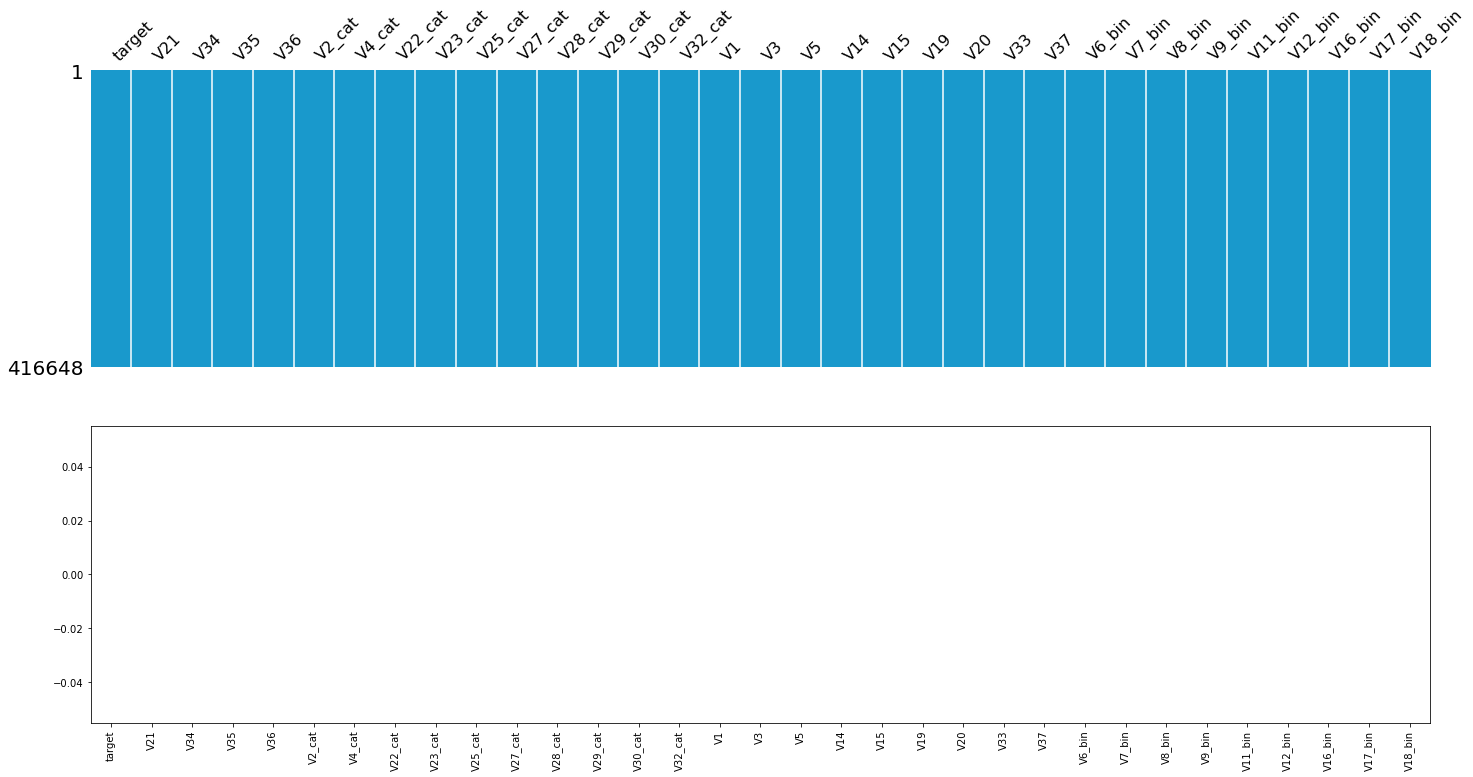

In [43]:
figure, axs = plt.subplots(nrows=2, ncols=1)
figure.set_size_inches(24,12)

msno.matrix(df=train_ii.iloc[:, :], color=(0.1, 0.6, 0.8),ax=axs[0])
train_ii.isna().sum().plot.bar(figsize = (24,12),color=(0.1, 0.6, 0.8))

보간 결과 결측치가 전부 보간되었음을 확인

In [45]:
# train_ii.to_csv('C:/Users/wpekt/Desktop/과제/P-SAT/방세/train_oe_br_hr.csv',index=False)
# test_ii.to_csv('C:/Users/wpekt/Desktop/과제/P-SAT/방세/test_oe_br_hr.csv',index=False)

보간 후 데이터 분포 확인->대체로 보간 전 데이터 분포와 유사함을 확인함.

In [46]:
train_pos_ii=train_ii[train_ii['target']==1]
train_neg_ii=train_ii[train_ii['target']==0]

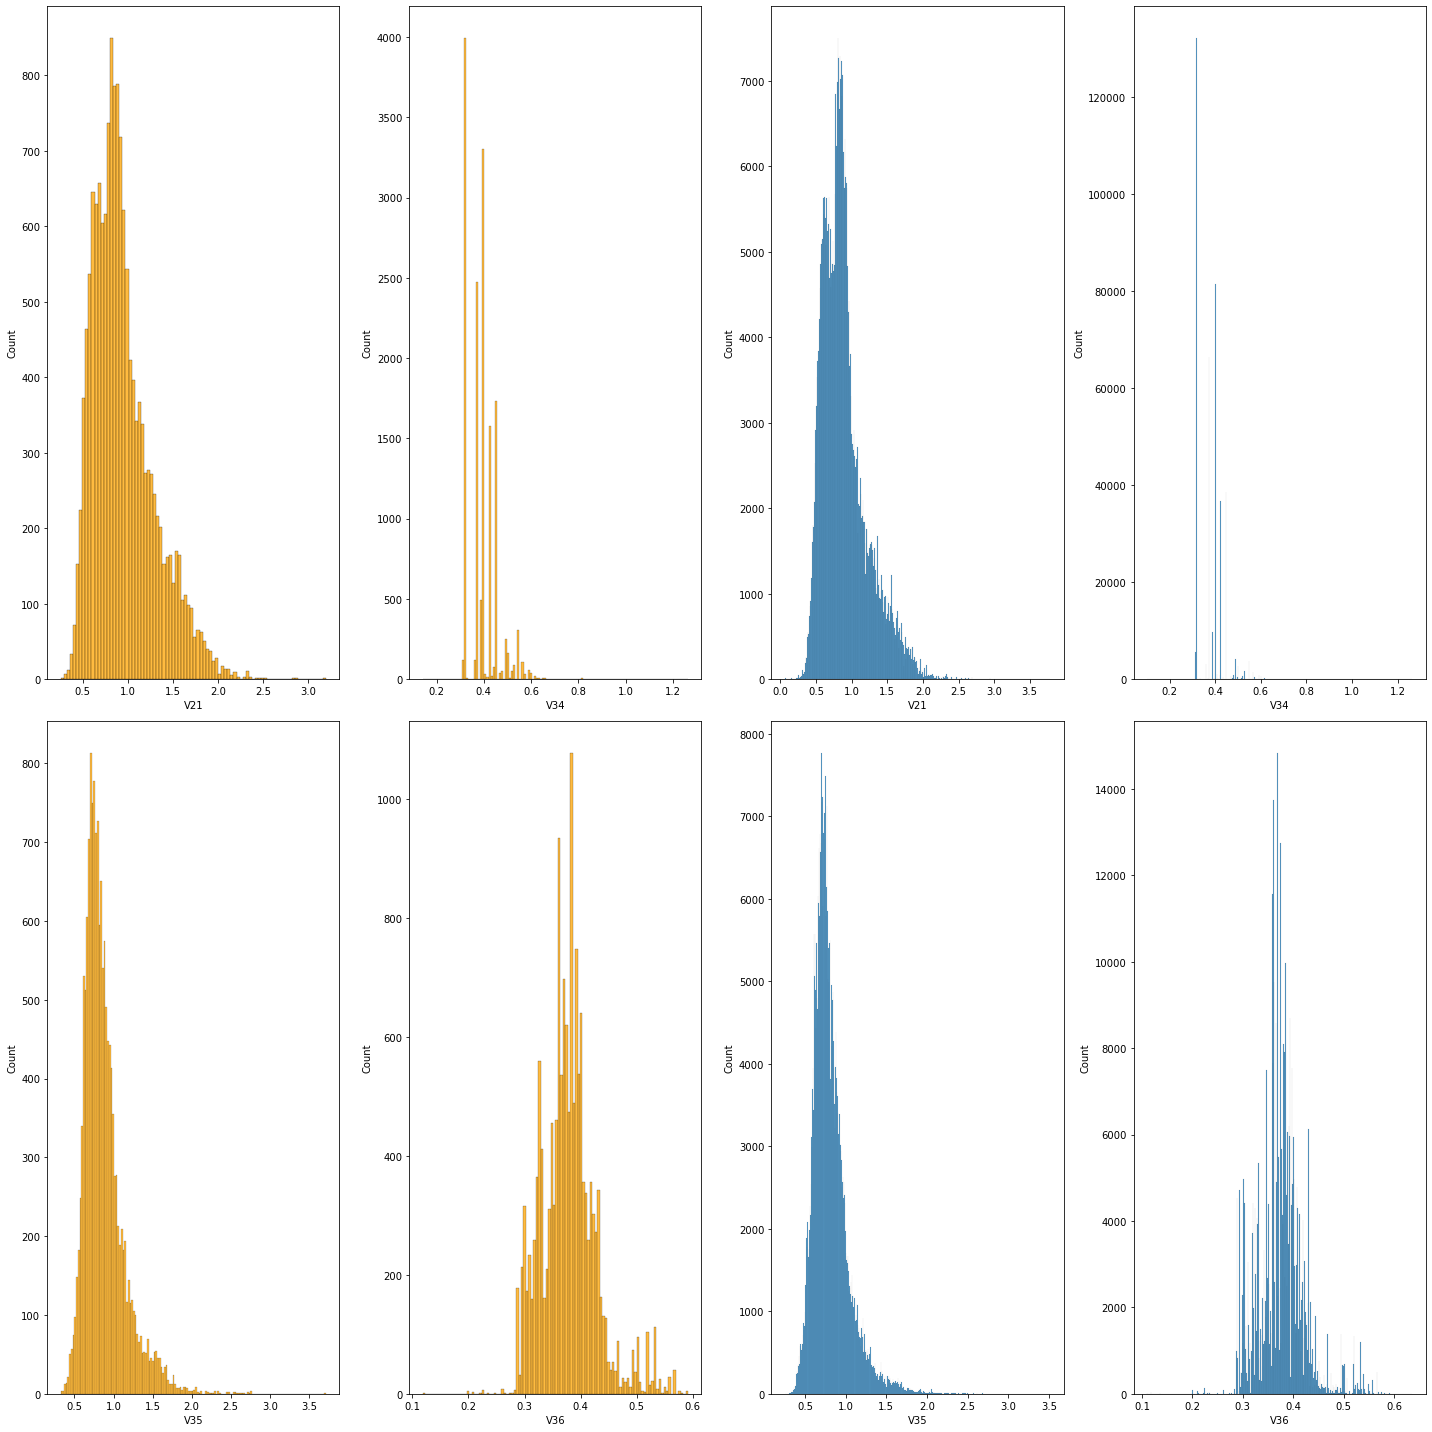

In [47]:
figure, axs = plt.subplots(nrows=(len(col_numh)//2), ncols=4)
figure.set_size_inches(20,20)

for i, col in enumerate(train_pos_ii[col_numh]):
    sns.histplot(train_pos_ii, x=col,color='orange',ax=axs[i//2,i%2])
    sns.histplot(train_neg_ii, x=col,ax=axs[i//2,i%2+2])
figure.tight_layout() 

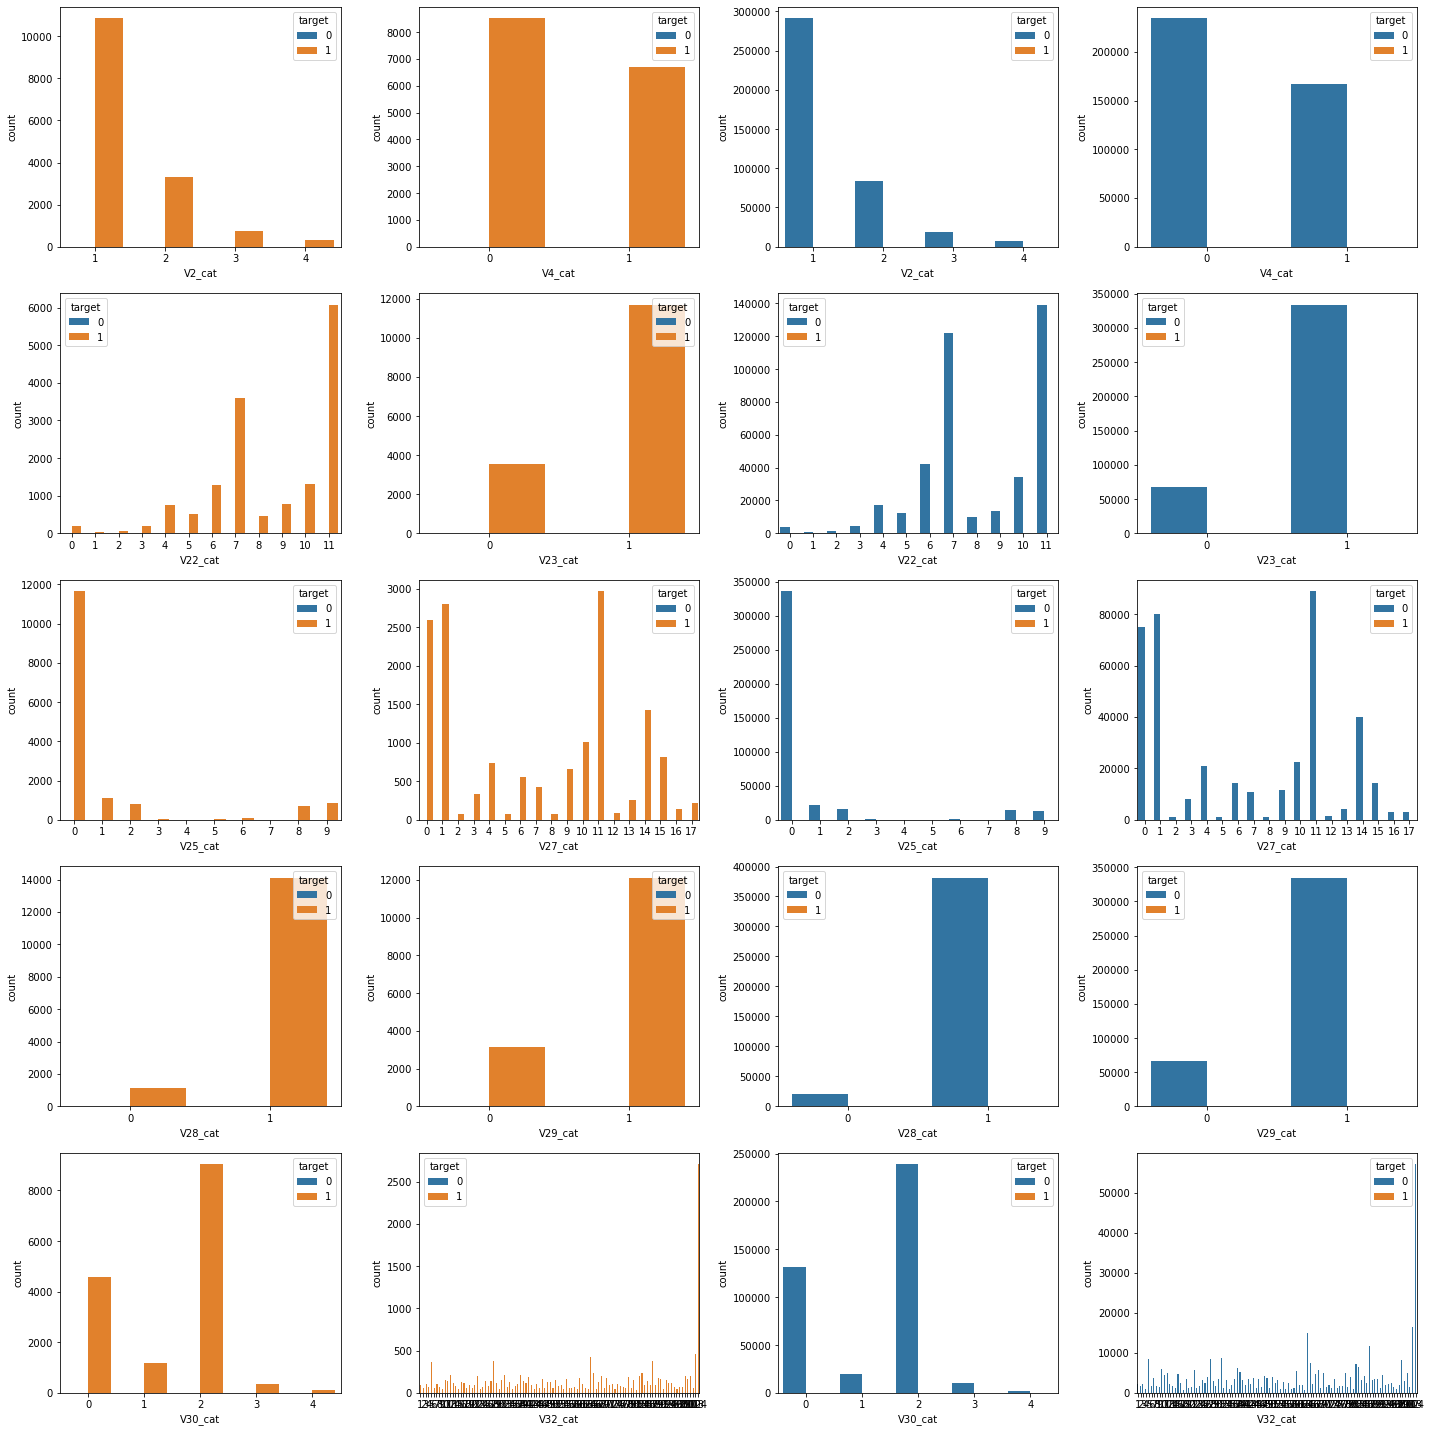

In [48]:
figure, axs = plt.subplots(nrows=(len(col_cath)//2), ncols=4)
figure.set_size_inches(20,20)

for i, col in enumerate(train_pos_ii[col_cath]):
    sns.countplot(x=train_pos_ii[col],hue=train_ii['target'],ax=axs[i//2,i%2])
    sns.countplot(x=train_neg_ii[col],hue=train_ii['target'],ax=axs[i//2,i%2+2])
figure.tight_layout() 

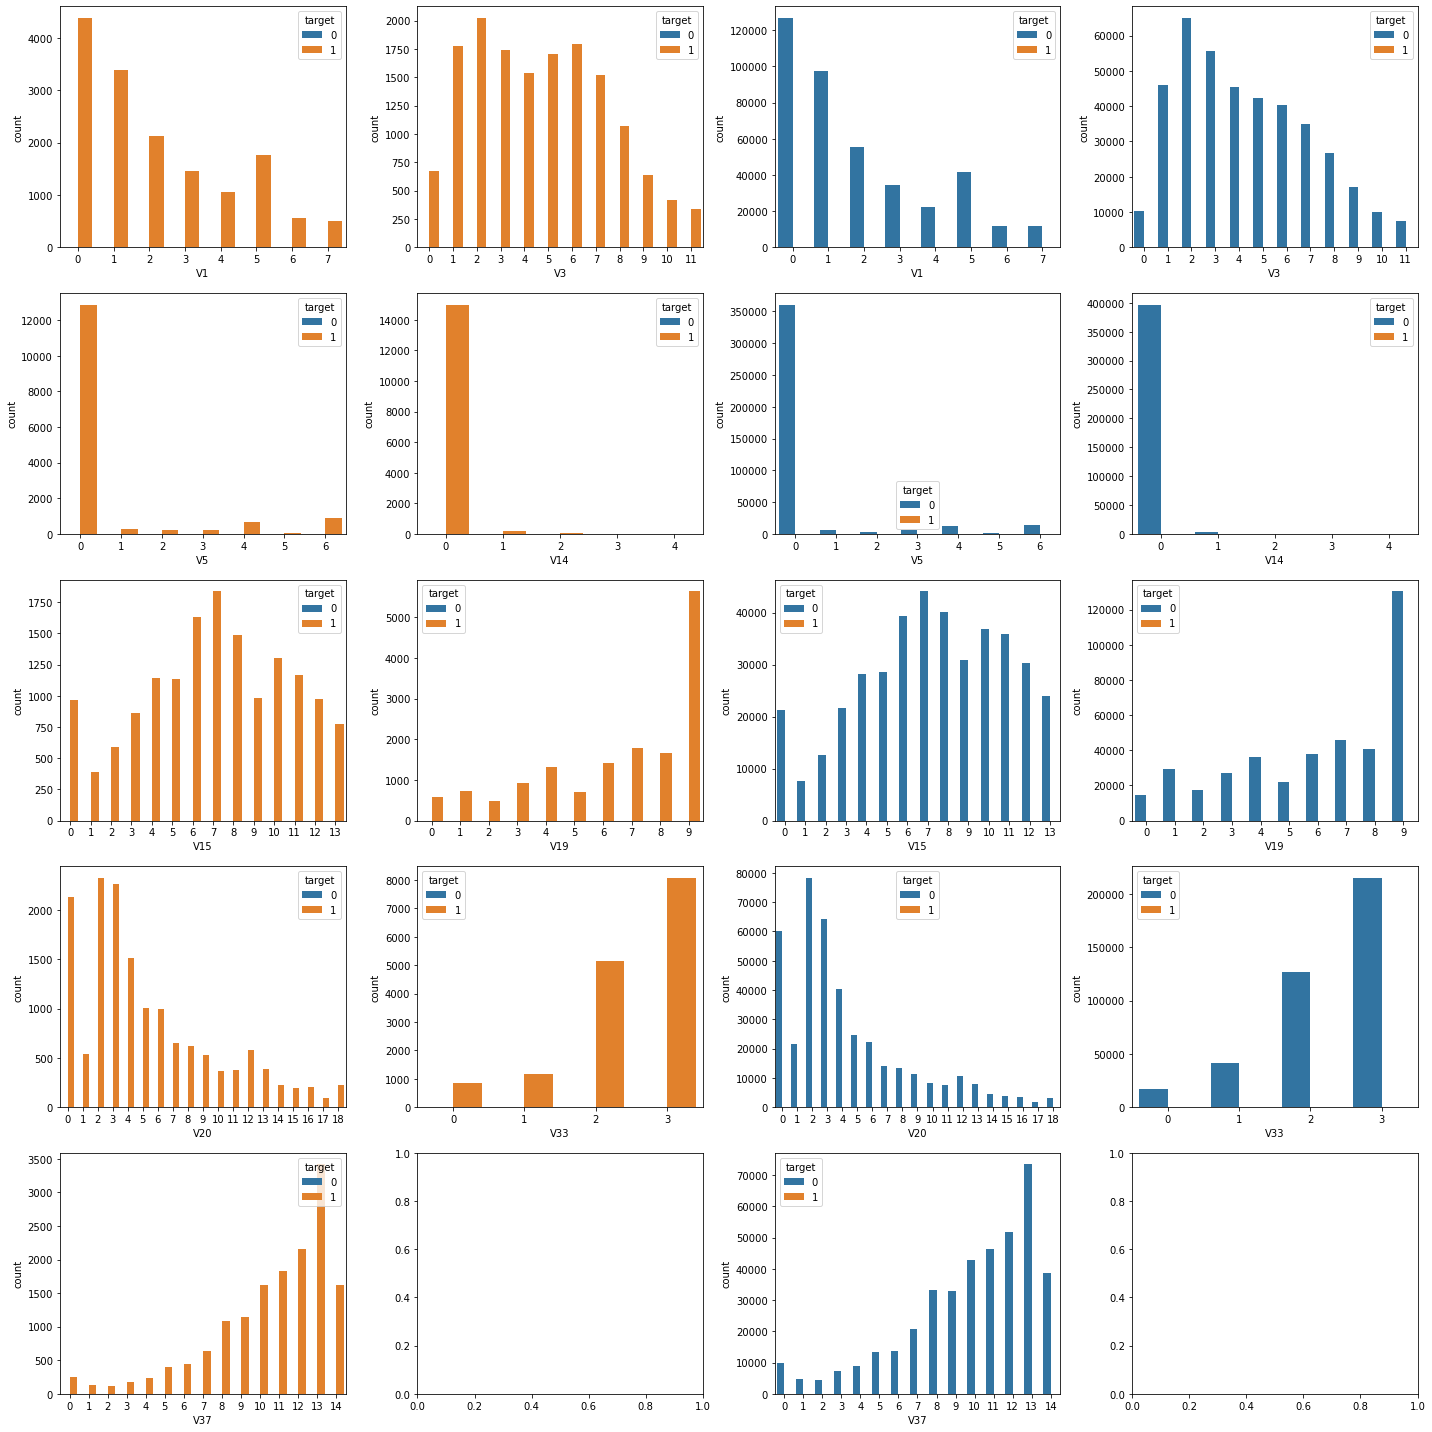

In [49]:
figure, axs = plt.subplots(nrows=(len(col_ordh)//2+1), ncols=4)
figure.set_size_inches(20,20)

for i, col in enumerate(train_pos_ii[col_ordh]):
    sns.countplot(x=train_pos_ii[col],hue=train_ii['target'],ax=axs[i//2,i%2])
    sns.countplot(x=train_neg_ii[col],hue=train_ii['target'],ax=axs[i//2,i%2+2])
figure.tight_layout() 

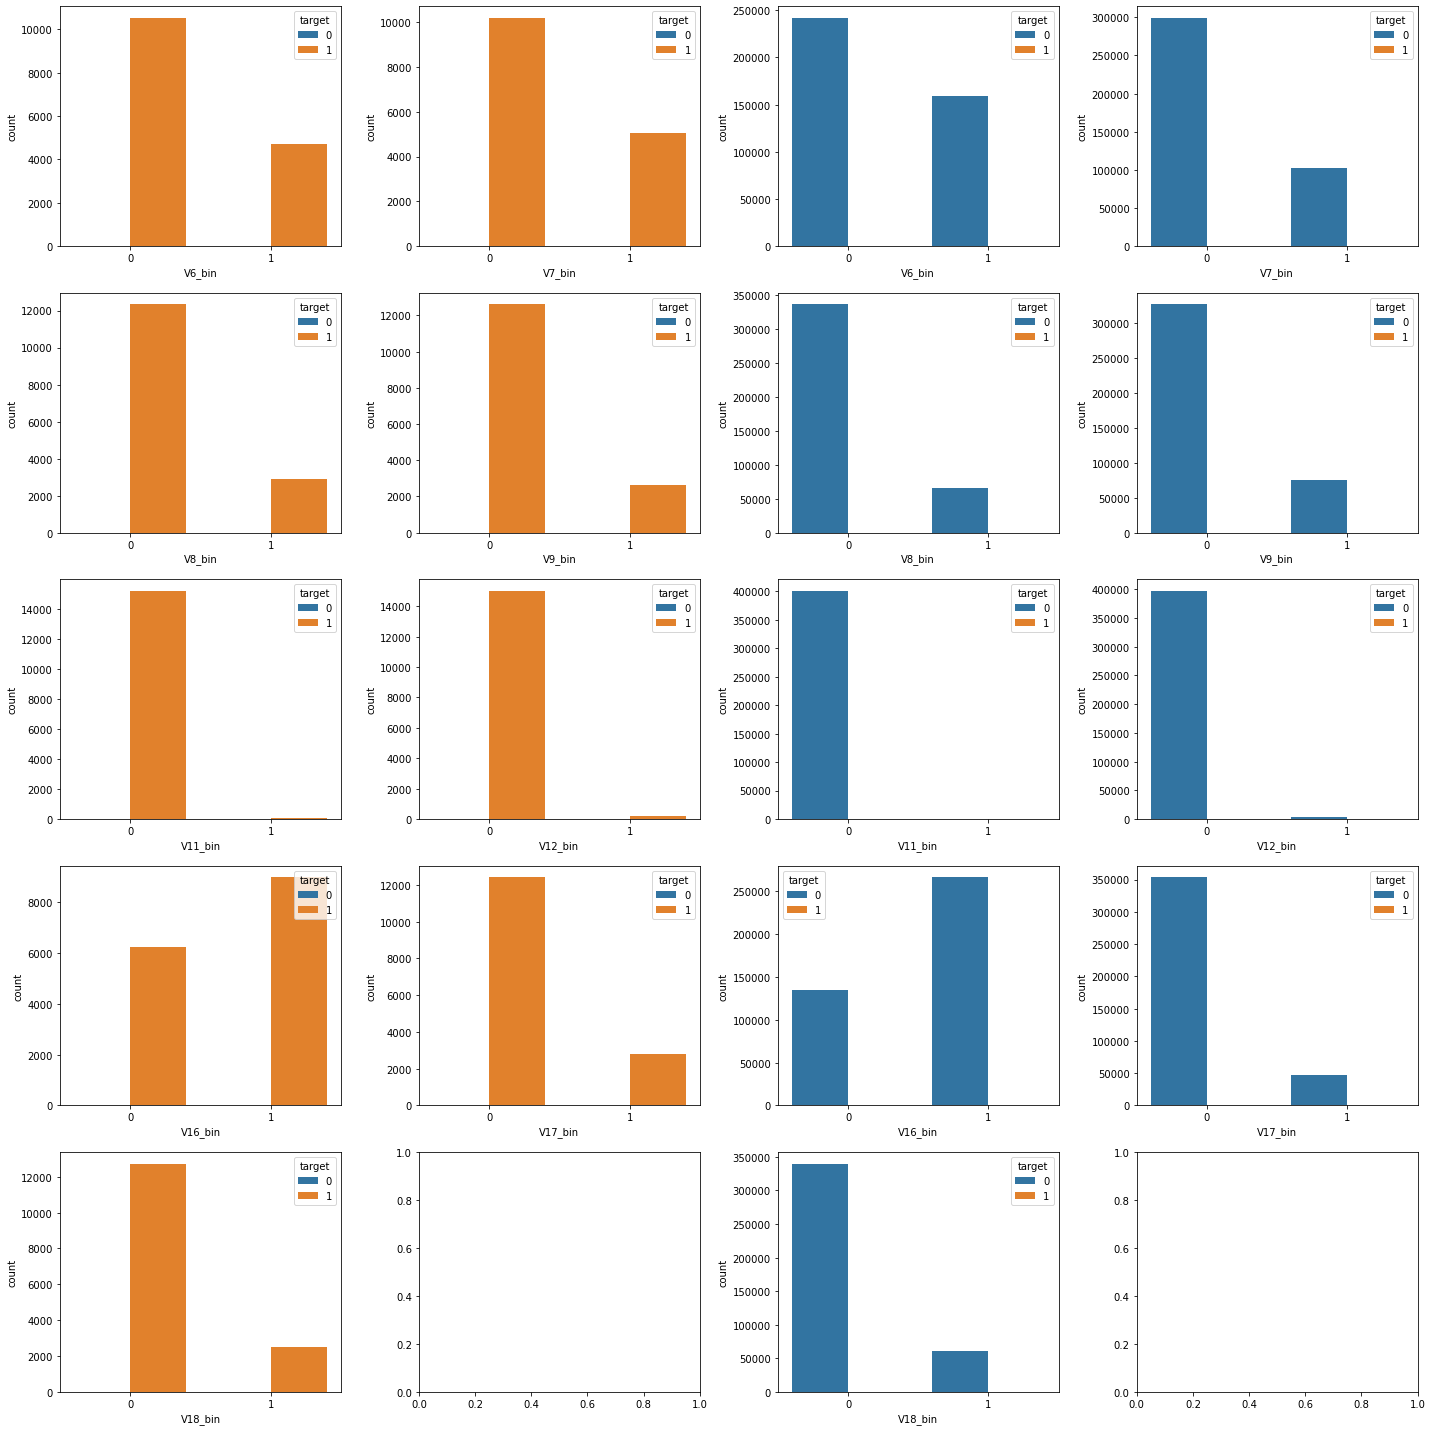

In [50]:
figure, axs = plt.subplots(nrows=(len(col_binh)//2+1), ncols=4)
figure.set_size_inches(20,20)

for i, col in enumerate(train_pos_ii[col_binh]):
    sns.countplot(x=train_pos_ii[col],hue=train_ii['target'],ax=axs[i//2,i%2])
    sns.countplot(x=train_neg_ii[col],hue=train_ii['target'],ax=axs[i//2,i%2+2])
figure.tight_layout() 